## Imports

In [1]:
import anndata as ad
import cellrank as cr
import jax
import magic
import matplotlib.pyplot as plt
import numpy as np
import orbax
import pandas as pd
import seaborn as sns
import yaml
from jax.nn import gelu
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer
from tqdm import tqdm

import spacetime
from spacetime import potentials, steps

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
# Set default Seaborn style
sns.set_theme("paper", "whitegrid")

## Load the data

In [3]:
# Load the data
adata = ad.read_h5ad(
    "/home/ghuizing/Documents/data/midbrain/dorsal_midbrain_processed.h5ad"
)

# Normalize the gene expression
adata.obsm["X_pca_harmony"] = adata.obsm["X_pca_harmony"][:, :20]
adata.obsm["X_pca_harmony"] /= adata.obsm["X_pca_harmony"].max()

## Load the weights

In [4]:
# Initialize the model.
step = steps.ExplicitStep()
my_model = spacetime.SpaceTime(
    potential=potentials.MLPPotential([128, 128], activation=gelu),
    proximal_step=step,
)

# Load the config
weights_path = "/home/ghuizing/Documents/runs/midbrain_june_quadratic_qbcc6u94/"
with open(weights_path + "config.yaml") as f:
    config = yaml.safe_load(f)

# Print the fused parameter
print("Quadratic weight:", config["model"]["quadratic_weight"])

# Define the checkpoint manager.
options = orbax.checkpoint.CheckpointManagerOptions(
    save_interval_steps=1,
    max_to_keep=1,
    best_fn=lambda x: x["loss"],
    best_mode="min",
)
checkpoint_manager = orbax.checkpoint.CheckpointManager(
    f"{weights_path}/checkpoints",
    orbax.checkpoint.PyTreeCheckpointer(),
    options=options,
)

# Restore the model.
best_epoch = checkpoint_manager.best_step()
my_model.params = checkpoint_manager.restore(best_epoch)

Quadratic weight: 0.001


## Panel A: Compute potential

In [5]:
# Compute the potential
potential_fn = lambda x: my_model.potential.apply(my_model.params, x)
adata.obs["potential"] = np.array(potential_fn(adata.obsm["X_pca_harmony"]))

# Save all this in a csv
df = pd.DataFrame(adata.obs)
df[["iso_1", "iso_2"]] = adata.obsm["X_isomap"]
df.to_csv("/home/ghuizing/Documents/midbrain_potential.csv")

## Penl B: Plot trajectory

In [6]:
# Compute the velocities
velo_fn = lambda x: -jax.vmap(jax.grad(potential_fn))(x)
adata.obsm["X_velo"] = np.array(velo_fn(adata.obsm["X_pca_harmony"]))

In [7]:
palette = {"GlioB": "#008941ff", "NeuB": "#ff34ffff", "RGC": "#00bfffff"}

100%|██████████| 4581/4581 [00:03<00:00, 1464.41cell/s]


saving figure to file ./figures/scvelo_midbrain_velocities.svg


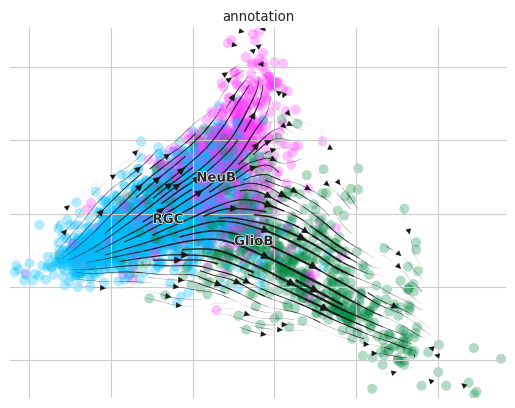

In [8]:
vk = cr.kernels.VelocityKernel(
    adata, attr="obsm", xkey="X_pca_harmony", vkey="X_velo"
).compute_transition_matrix()
vk.plot_projection(
    basis="isomap",
    recompute=True,
    color="annotation",
    save="midbrain_velocities.svg",
    palette=palette,
)

## Fit gene regressions

In [9]:
# Subset to trajectory 1
adata = adata[adata.obs["annotation"].isin(["RGC", "GlioB"])].copy()

In [10]:
magic_operator = magic.MAGIC()
magic_operator.fit(adata.obsm["X_pca_harmony"])
diff_op_t = np.linalg.matrix_power(magic_operator.diff_op.A, 3)
adata.X = diff_op_t @ np.log1p(adata.layers["counts"].A)

Running MAGIC on 3643 cells and 20 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.26 seconds.
  Calculating affinities...
  Calculated affinities in 0.25 seconds.
Calculated graph and diffusion operator in 0.52 seconds.


In [11]:
# We want to regress gene expression from the potential
x_train = np.array(adata.obs["potential"]).reshape(-1, 1).astype(np.float64)

# The model is a spline regression
model = make_pipeline(
    SplineTransformer(
        knots="quantile",
        extrapolation="continue",
    ),
    LinearRegression(),
)

# Fit the model for each gene and keep the score and argmax
for gene in tqdm(adata.var_names):

    # The target gene expression
    y_train = adata[:, gene].X.ravel()

    # Fit the model
    model.fit(x_train, y_train)

    # Store the results
    adata.var.loc[gene, "score"] = model.score(x_train, y_train)
    adata.var.loc[gene, "argmax"] = model.predict(np.sort(x_train, axis=0)).argmax()

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:53<00:00, 188.08it/s]


In [12]:
idx = np.array(adata.var["score"]) != 1.0
adata = adata[:, idx].copy()

## Panel C: show trends

In [13]:
n_stages = 2
n_genes = 15
i_list = np.arange(0, adata.n_obs, adata.n_obs // n_stages)

gene_names = []
for k in range(len(i_list) - 1):

    # We'll look for the best genes in this interval
    i_min, i_max = i_list[k], i_list[k + 1]
    order_idx = i_min <= np.array(adata.var["argmax"])
    order_idx &= np.array(adata.var["argmax"]) < i_max

    for j, i in enumerate(
        np.where(order_idx)[0][
            np.argsort(np.array(adata.var["score"])[order_idx])[::-1][:n_genes]
        ]
    ):
        gene_names.append(adata.var_names[i])

In [14]:
def plot_gene_trends(gene_names):

    fig, axes = plt.subplots(
        2, 1, gridspec_kw={"height_ratios": [1, 25]}, figsize=(8, 5)
    )

    x_train = np.array(adata.obs["potential"])  # The potential
    X = np.zeros((len(gene_names), len(x_train)))  # Initialize the matrix to plot

    sorted_genes_names = adata.var.loc[gene_names, "argmax"].sort_values().index

    # Iterate of the genes
    for i, g in enumerate(sorted_genes_names):

        # Fit the model
        y_train = adata[:, g].X.ravel()
        model.fit(x_train.reshape(-1, 1), y_train)

        # Populate the matrix
        X[i] = model.predict(x_train.reshape(-1, 1))

    # Order the potential
    X = X[:, np.argsort(x_train)]

    # Normalize rows
    X = X - X.min(axis=1)[:, None]
    X = X / X.max(axis=1)[:, None]
    implot = axes[1].imshow(X, aspect="auto", cmap="viridis", interpolation="none")

    # Set sorted_genes_names as yticks with small font size
    axes[1].set_yticks(
        np.arange(0, X.shape[0]),
        sorted_genes_names,
        fontstyle="italic",
        fontsize=6,
    )
    axes[1].grid(None)

    implot2 = axes[0].imshow(
        adata.obs["annotation"].cat.codes.to_numpy().reshape(1, -1),
        aspect="auto",
        cmap="tab10",
        interpolation="none",
    )
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].spines["top"].set_visible(False)
    axes[0].spines["bottom"].set_visible(False)
    axes[0].spines["right"].set_visible(False)
    axes[0].spines["left"].set_visible(False)

    fig.colorbar(implot)
    fig.colorbar(implot2)

    plt.suptitle("Gene trends along gliogenesis")
    plt.savefig(
        "/home/ghuizing/Documents/notebooks/trajectories/figures/midbrain_gene_trends.svg"
    )
    plt.show()

    return sorted_genes_names

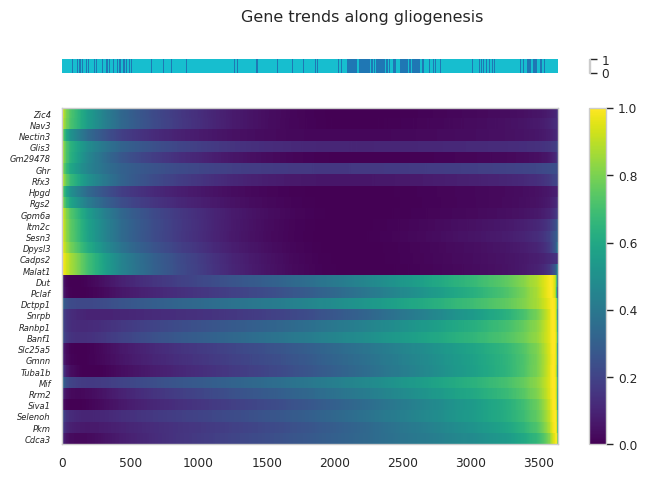

In [15]:
sorted_genes_names = plot_gene_trends(gene_names)

## Panel D: compare to paper

In [16]:
def plot_cells(gene):
    sns.scatterplot(
        x=adata.obs["potential"],
        y=adata[:, gene].X.ravel(),
        hue=adata.obs["annotation"],
        s=5,
        palette=palette,
        alpha=0.75,
    )

    model.fit(
        adata.obs["potential"].to_numpy().reshape(-1, 1),
        adata[:, gene].X.ravel(),
    )
    xx = np.linspace(
        adata.obs["potential"].quantile(0.02),
        adata.obs["potential"].quantile(0.98),
        100,
    )
    yy = model.predict(xx.reshape(-1, 1))
    sns.lineplot(x=xx, y=yy)
    sns.despine()

    plt.xlim(
        (adata.obs["potential"].quantile(0.01), adata.obs["potential"].quantile(0.99))
    )
    plt.title(gene, fontstyle="italic")
    plt.legend(markerscale=3)
    plt.savefig(
        "/home/ghuizing/Documents/notebooks/trajectories/figures/midbrain_gene_"
        + gene
        + ".svg"
    )
    plt.show()

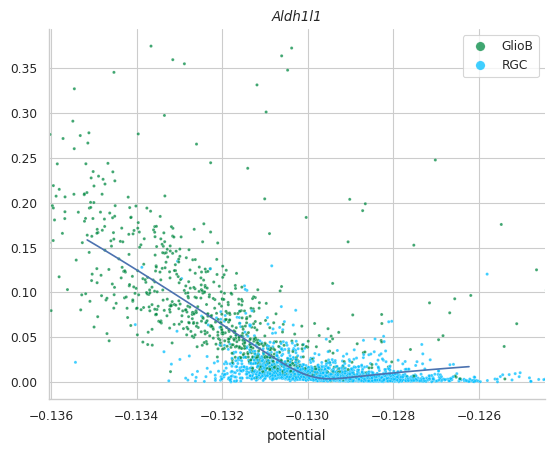

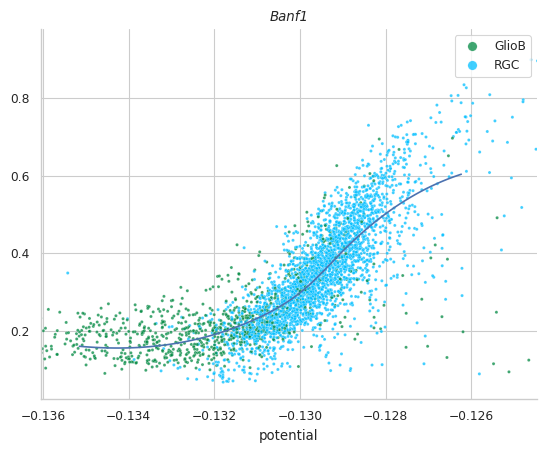

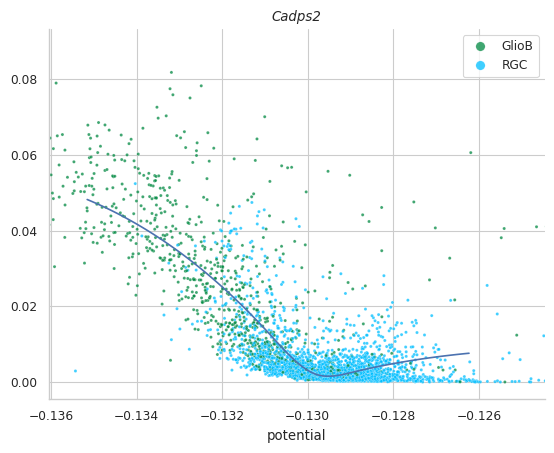

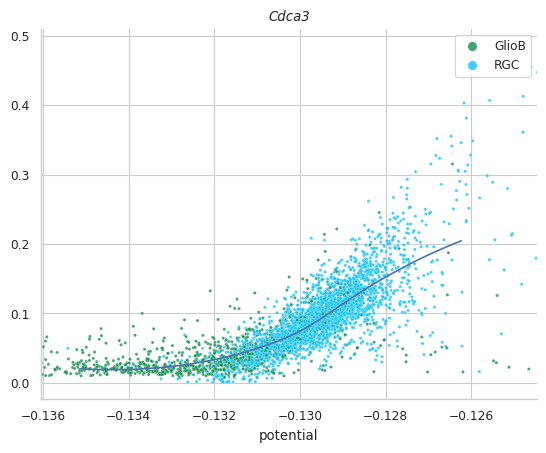

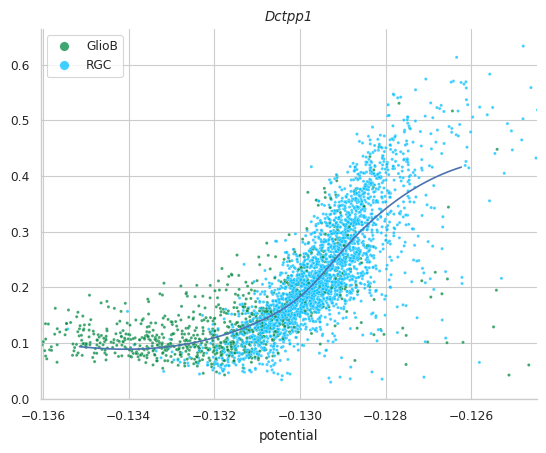

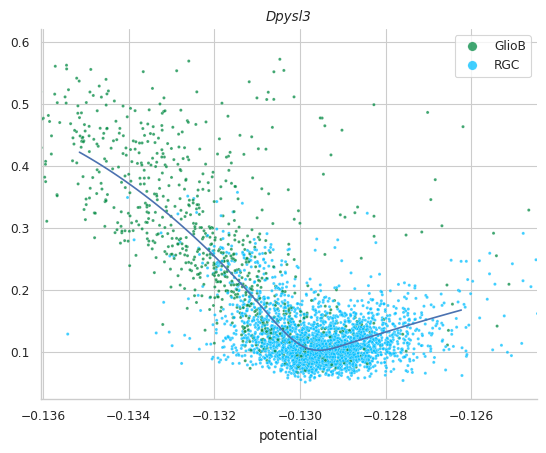

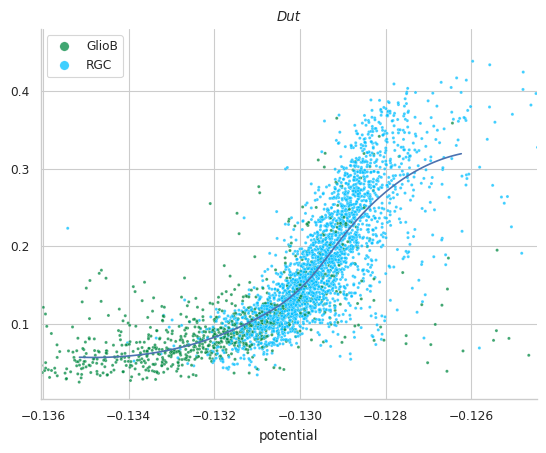

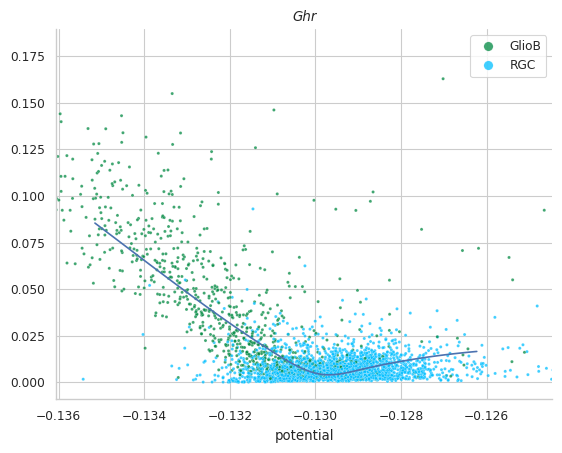

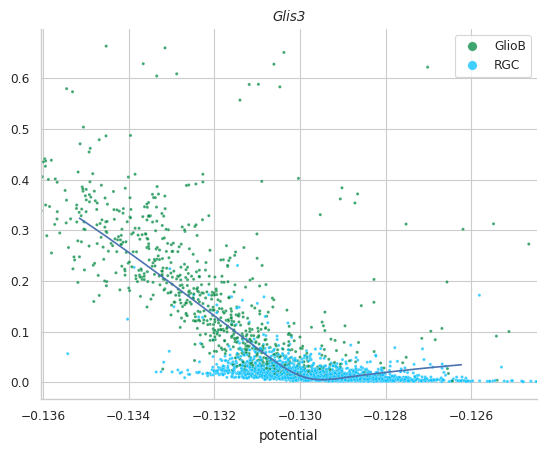

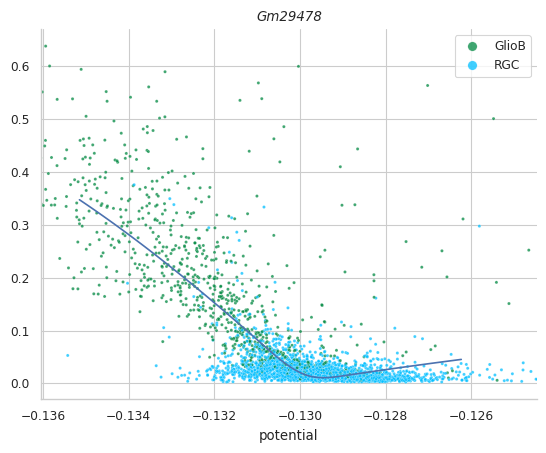

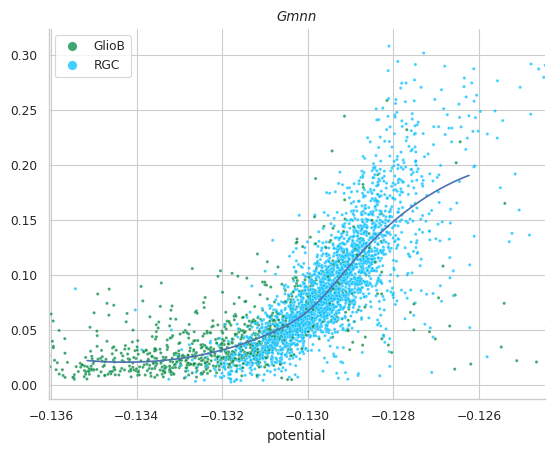

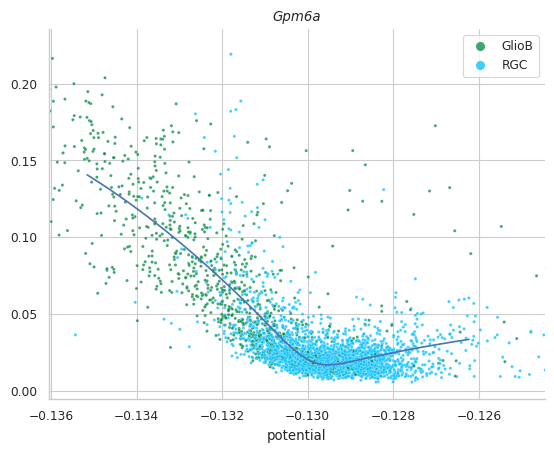

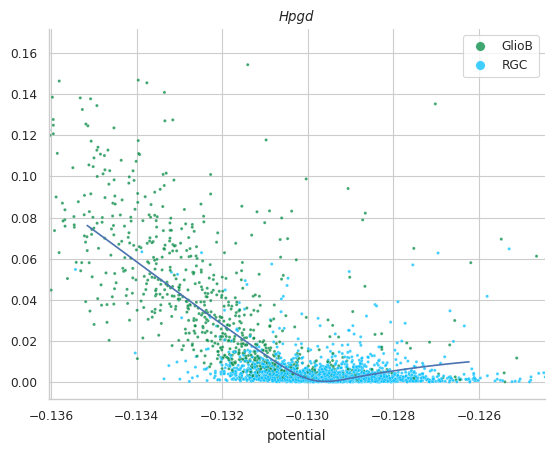

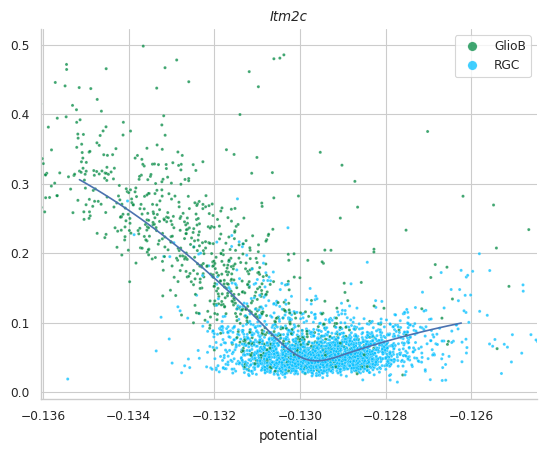

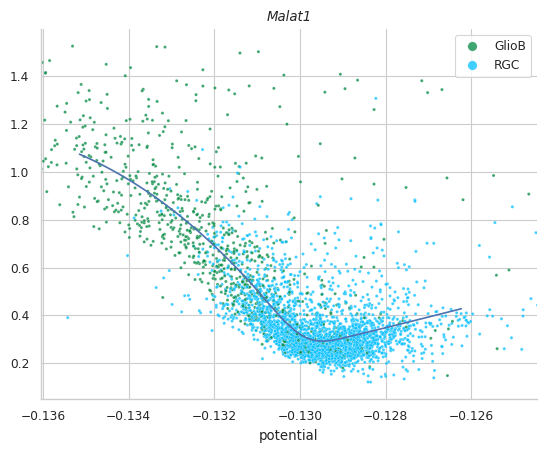

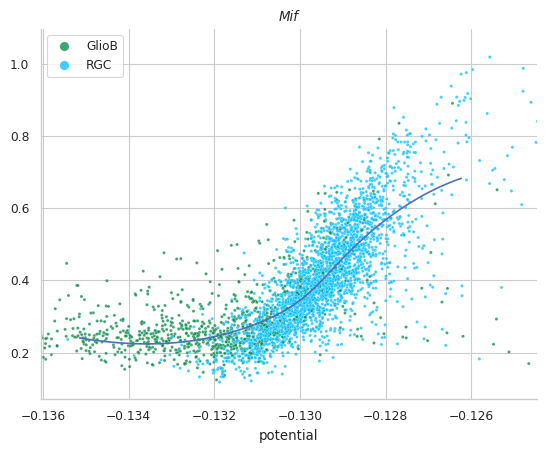

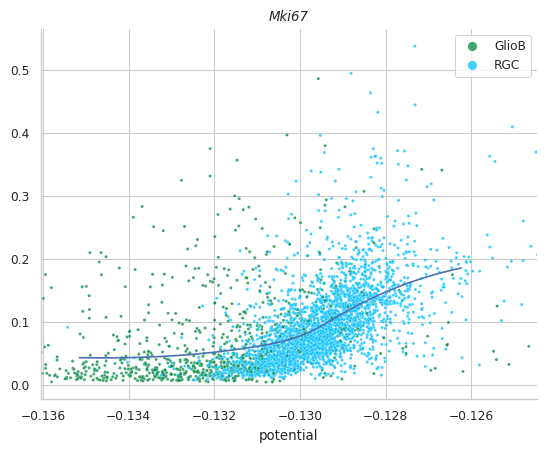

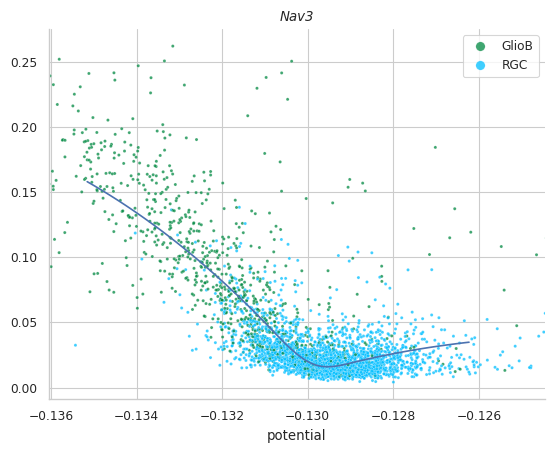

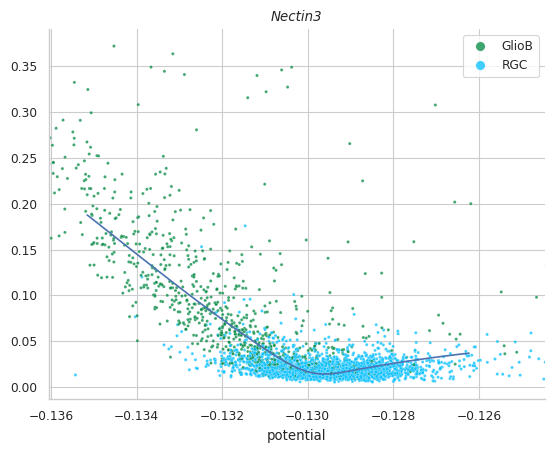

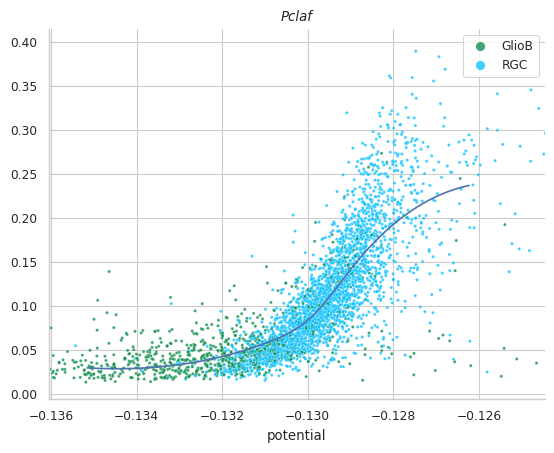

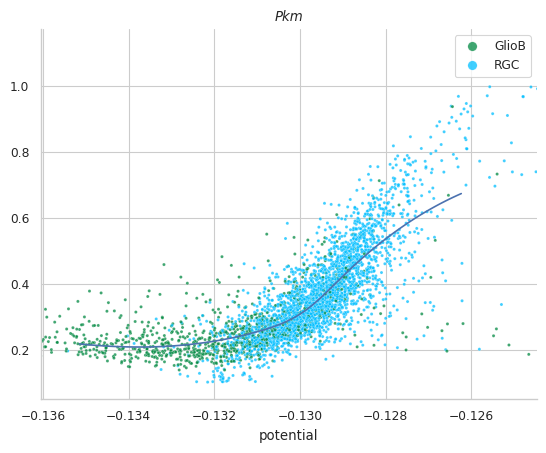

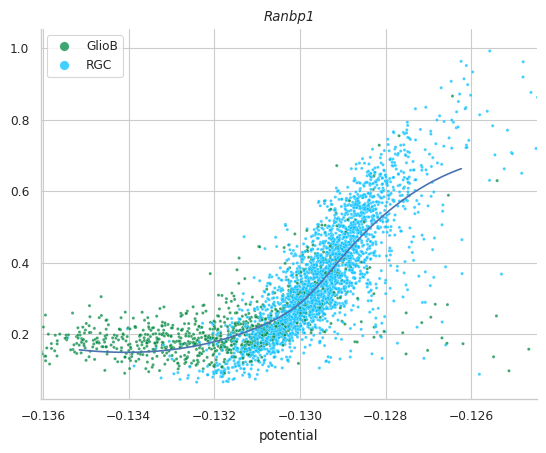

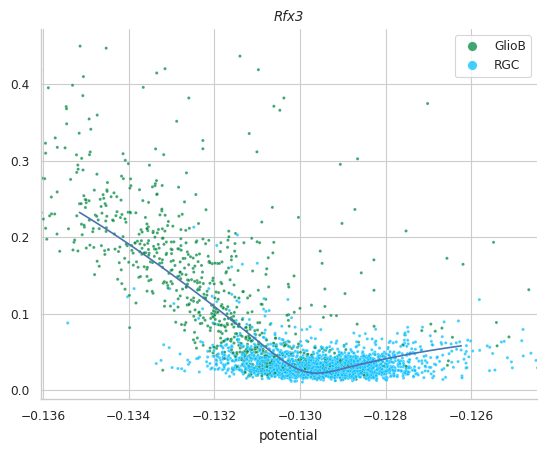

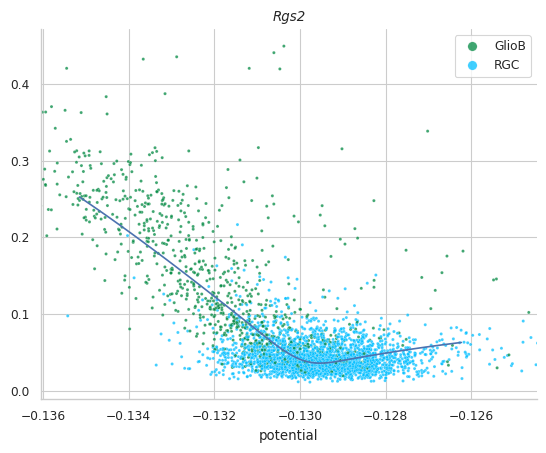

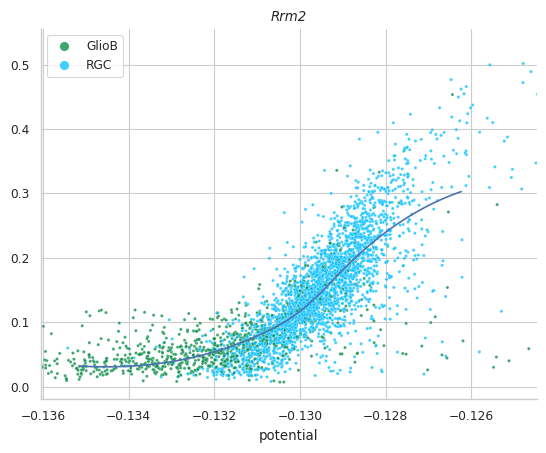

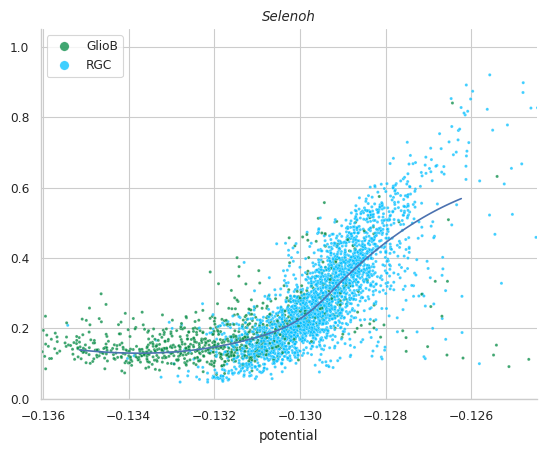

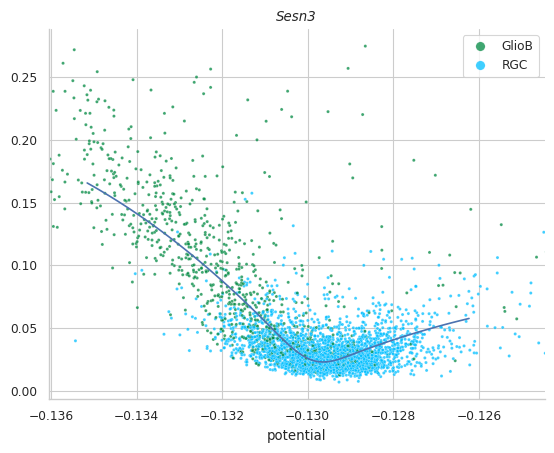

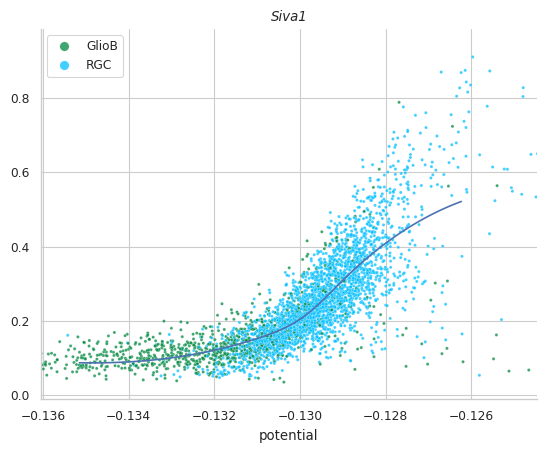

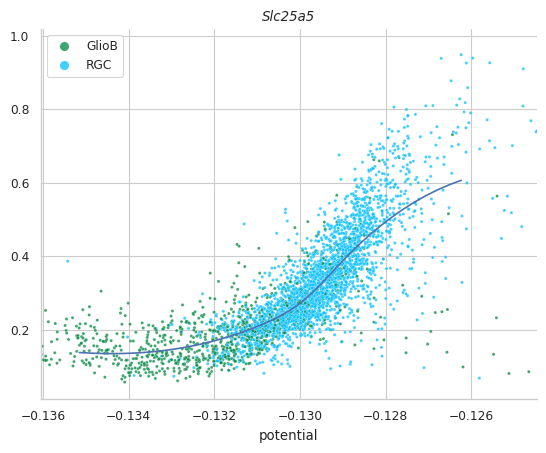

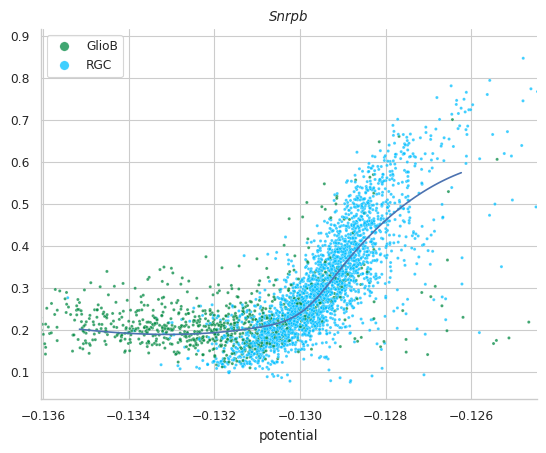

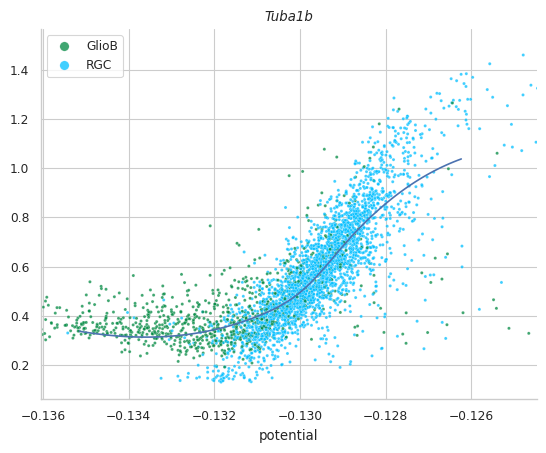

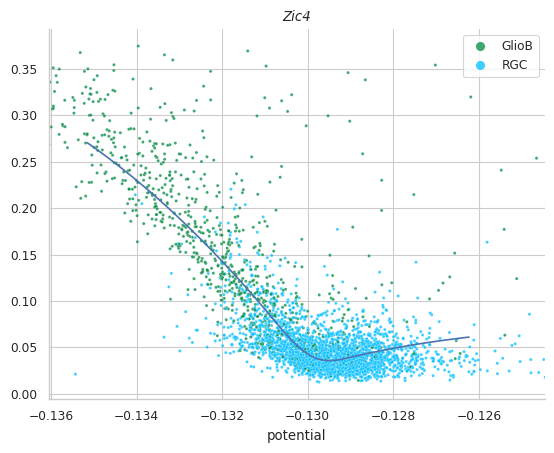

In [17]:
for gene in np.union1d(
    sorted_genes_names,
    [
        "Mki67",
        "Aldh1l1",
    ],
):
    plot_cells(gene)

In [18]:
for gene in sorted_genes_names:
    term = gene + " gliogenesis"
    print(gene, "\t", f"https://pubmed.ncbi.nlm.nih.gov/?term={term.replace(' ', '+')}")

Zic4 	 https://pubmed.ncbi.nlm.nih.gov/?term=Zic4+gliogenesis
Nav3 	 https://pubmed.ncbi.nlm.nih.gov/?term=Nav3+gliogenesis
Nectin3 	 https://pubmed.ncbi.nlm.nih.gov/?term=Nectin3+gliogenesis
Glis3 	 https://pubmed.ncbi.nlm.nih.gov/?term=Glis3+gliogenesis
Gm29478 	 https://pubmed.ncbi.nlm.nih.gov/?term=Gm29478+gliogenesis
Ghr 	 https://pubmed.ncbi.nlm.nih.gov/?term=Ghr+gliogenesis
Rfx3 	 https://pubmed.ncbi.nlm.nih.gov/?term=Rfx3+gliogenesis
Hpgd 	 https://pubmed.ncbi.nlm.nih.gov/?term=Hpgd+gliogenesis
Rgs2 	 https://pubmed.ncbi.nlm.nih.gov/?term=Rgs2+gliogenesis
Gpm6a 	 https://pubmed.ncbi.nlm.nih.gov/?term=Gpm6a+gliogenesis
Itm2c 	 https://pubmed.ncbi.nlm.nih.gov/?term=Itm2c+gliogenesis
Sesn3 	 https://pubmed.ncbi.nlm.nih.gov/?term=Sesn3+gliogenesis
Dpysl3 	 https://pubmed.ncbi.nlm.nih.gov/?term=Dpysl3+gliogenesis
Cadps2 	 https://pubmed.ncbi.nlm.nih.gov/?term=Cadps2+gliogenesis
Malat1 	 https://pubmed.ncbi.nlm.nih.gov/?term=Malat1+gliogenesis
Dut 	 https://pubmed.ncbi.nlm.nih.gov/?t

## Panel E: TF targets

In [19]:
df_tf = pd.read_csv(
    "/home/ghuizing/Documents/data/trrust_rawdata.mouse.tsv", sep="\t", header=None
)
df_tf.columns = ["TF", "Target", "Mode", "References"]
df_tf = df_tf[df_tf["Target"].isin(adata.var_names)]

In [20]:
df_tf

,TF,Target,Mode,References
1,Aatf,Bax,Unknown,22983126
2,Aatf,Bbc3,Unknown,22983126
3,Aatf,Cdkn1a,Unknown,21317046
4,Aatf,Tpt1,Activation,17157788
5,Aatf,Trp53,Activation,17157788;20708154
...,...,...,...,...
7042,Zfpm2,Sox9,Unknown,17540364
7044,Zhx3,Zhx1,Unknown,17056598
7045,Zhx3,Zhx2,Unknown,17056598
7046,Zic1,Abhd14a,Activation,14667578


In [21]:
for tf in tqdm(df_tf["TF"].unique()):
    idx = df_tf["TF"] == tf
    adata.var[tf] = 0.0

    # Iterate over rows of df_tf[idx]:
    for target in df_tf.loc[idx, "Target"]:
        adata.var.loc[adata.var_names == target, tf] = 1

100%|██████████| 599/599 [00:02<00:00, 281.95it/s]


In [22]:
from scipy.stats import ranksums

df_tf_stats = pd.DataFrame(index=df_tf["TF"].unique())
for tf in tqdm(df_tf_stats.index):

    idx_target = adata.var[tf] > 0
    target_scores = adata.var.loc[idx_target, "score"].values.astype(float)

    idx_nontarget = adata.var[tf] == 0
    nontarget_scores = adata.var.loc[idx_nontarget, "score"].values.astype(float)

    stat, p_value = ranksums(target_scores, nontarget_scores, alternative="greater")
    df_tf_stats.loc[tf, ["stat", "p_value", "n_targets"]] = (
        stat,
        p_value,
        idx_target.sum(),
    )

100%|██████████| 599/599 [00:01<00:00, 560.22it/s]


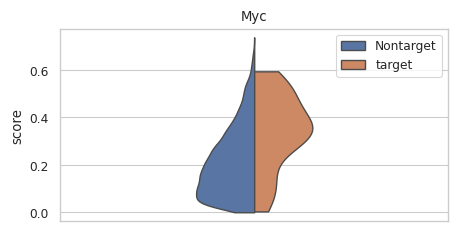

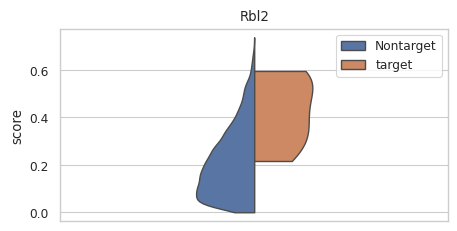

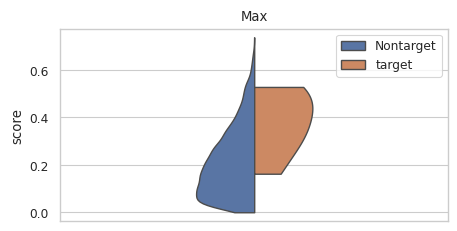

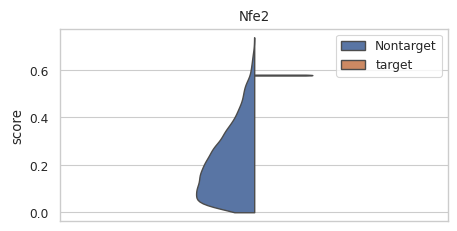

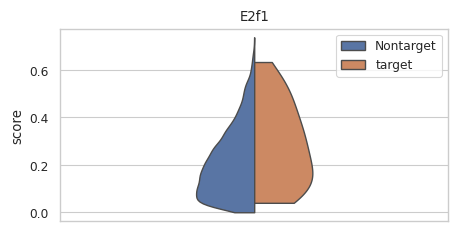

In [23]:
for tf in df_tf_stats.sort_values("p_value").index[:5]:
    idx = ["target" if x > 0 else "Nontarget" for x in adata.var[tf]]
    fig, ax = plt.subplots(figsize=(5, 2.5))
    plt.title(tf)
    sns.violinplot(
        data=adata.var,
        hue=idx,
        y="score",
        split=True,
        inner=None,
        cut=0,
        ax=ax,
        width=0.3,
    )
    plt.show()

In [24]:
idx = df_tf_stats["p_value"] < 0.05
for tf in df_tf_stats[idx].sort_values("p_value").index:
    term = tf + " brain development"
    print(tf, "\t", f"https://pubmed.ncbi.nlm.nih.gov/?term={term.replace(' ', '+')}")

Myc 	 https://pubmed.ncbi.nlm.nih.gov/?term=Myc+brain+development
Rbl2 	 https://pubmed.ncbi.nlm.nih.gov/?term=Rbl2+brain+development
Max 	 https://pubmed.ncbi.nlm.nih.gov/?term=Max+brain+development
Nfe2 	 https://pubmed.ncbi.nlm.nih.gov/?term=Nfe2+brain+development
E2f1 	 https://pubmed.ncbi.nlm.nih.gov/?term=E2f1+brain+development
Nfat5 	 https://pubmed.ncbi.nlm.nih.gov/?term=Nfat5+brain+development
Sox4 	 https://pubmed.ncbi.nlm.nih.gov/?term=Sox4+brain+development
Notch2 	 https://pubmed.ncbi.nlm.nih.gov/?term=Notch2+brain+development
Pthlh 	 https://pubmed.ncbi.nlm.nih.gov/?term=Pthlh+brain+development
Klf3 	 https://pubmed.ncbi.nlm.nih.gov/?term=Klf3+brain+development
Kat5 	 https://pubmed.ncbi.nlm.nih.gov/?term=Kat5+brain+development
Klf5 	 https://pubmed.ncbi.nlm.nih.gov/?term=Klf5+brain+development
Tfap2a 	 https://pubmed.ncbi.nlm.nih.gov/?term=Tfap2a+brain+development
Jdp2 	 https://pubmed.ncbi.nlm.nih.gov/?term=Jdp2+brain+development
Nr3c1 	 https://pubmed.ncbi.nlm.nih.gov/

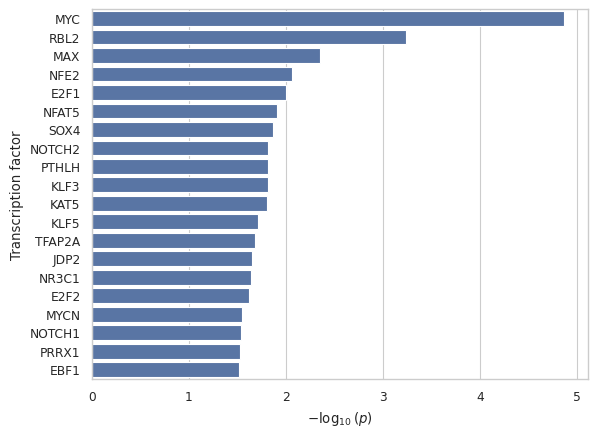

In [25]:
idx = df_tf_stats["p_value"] < 0.05
tf_names = df_tf_stats[idx].sort_values("p_value").index[:20]
sns.barplot(y=tf_names.str.upper(), x=-np.log10(df_tf_stats.loc[tf_names, "p_value"]))
plt.ylabel("Transcription factor")
plt.xlabel(r"$-\log_{10}(p)$")
plt.savefig("/home/ghuizing/Documents/notebooks/trajectories/figures/midbrain_tf.svg")